# Images with Neural Networks

This notebook makes extensive use of examples and figures from [here](http://cs231n.github.io/convolutional-networks/), which is a great reference for further details.


# GOALS

* Understand how Image data is stored and used
* Write a Multi-Class classification model
* Be able to use convolutional layers
* Build a network for Image Classification
* Understand Over-fitting and some ways to deal with it

# Example: MNIST - Fashion

For this example we'll use MNIST- Fashion, a collection of small 28x28 pixel images of various pieces of clothing. It is a common benchmark along with with the original MNIST which is a collection of hand written digits. We will load the data directly from keras.



## The Task
This is a multi-class classification problem, identify the type of object in the image

|Label| Class  |
|------ | ------|
|    0|T-shirt/top|
|    1|Trouser|
|    2| Pullover|
|    3| Dress|
|    4| Coat|
|    5| Sandal|
|    6| Shirt|
|    7| Sneaker|
|    8| Bag|
|    9| Ankle boot|
 



## Image Data 

Here we'll rely on tensorflow and the handy package Keras that comes with it

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='' #If you installed tensorflow to work with a GPU this will disable it
import os.path
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from random import random
from sys import version
print("Import complete")    #Jake, this takes a bit to run, added print statement

Import complete


A Single Image:
 [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0   0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62  54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134 144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178 107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216 216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   0 200 232 2

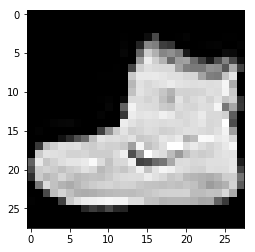

Example Label: 9


In [2]:
# Load pre-shuffled MNIST data into train and test sets
(_xtrain, _ytrain), (X_test, Y_test) = tf.keras.datasets.fashion_mnist.load_data()

#We want to include a develop set so let's split the training set
train_index=[]
develop_index=[]
for i in range(len(_xtrain)):
    if random() <0.8:
        train_index.append(i)
    else:
        develop_index.append(i)
X_train=_xtrain[train_index]
Y_train=_ytrain[train_index]

X_develop=_xtrain[develop_index]
Y_develop=_ytrain[develop_index]


#Jake, is there a way we can get jupyter notebook to not wrap the arrays?
np.set_printoptions(linewidth=115)
n_targets=np.max(Y_test)+1
print('A Single Image:\n',X_train[0])
plt.imshow(X_train[0],cmap='gray')
plt.show()
print('Example Label:', Y_train[0])

* Note above that the labels are integers from 0-9
* Also note the images are integers from 0-255 (uint8)

We will deal with the labels first. Lets make some useful arrays and dictionaries to keep track of what each integer means 

In [3]:
# This is useful for making plots it takes an integer
lookup_dict={
    0 :'T-shirt/top',
    1 :'Trouser',
    2 :'Pullover',
    3 :'Dress',
    4 :'Coat',
    5 :'Sandal',
    6 :'Shirt',
    7 :'Sneaker',
    8 :'Bag',
    9 :'Ankle boot' 
}


#Lets make a list in the order of the labels above so [T-Shirt,Trouser,...]
labels=list(lookup_dict.values())

#Check to make sure labels list is in the right order (not guaranteed in python < 3.6)
if not all([v==lookup_dict[i] for i,v in enumerate(labels) ]):
    print('This looks like an old version of python making labels the long way, you are using python version', version)
    labels=['' for i in range(n_targets) ] #make a list with the right size
    for key in lookup_dict:
        labels[key]=lookup_dict[key] #Assign list to the vaules
        
#Always good to make simple checks that what you think is going to work actually is working
#Here we check that our array of labels is in the same order as the dictionary we wrote above
assert(all([v==lookup_dict[i] for i,v in enumerate(labels) ]))
print("Array and dictionary are in same order")    #Jake, added positive feedback if assert passes

#Another Simple Check (Keras is well tested this will work, but it's good to get in the habit when using your own data)
assert(len(X_train)==len(Y_train))
print("X_train and Y_train are the same length")   #Jake, added positive feedback if assert passes
assert(len(X_develop)==len(Y_develop))
print("X_develop and Y_develop are the same length")    #Jake, added positive feedback if assert passes
assert(len(X_test)==len(Y_test))
print("X_test and Y_test are the same length")    #Jake, added positive feedback if assert passes

Array and dictionary are in same order
X_train and Y_train are the same length
X_develop and Y_develop are the same length
X_test and Y_test are the same length


# Multi-Class Classification

**Reminder**
   * Classification is problem where each of our examples (x) belongs to a class (y). Since Neural networks are universal function approximators, we can use $P(y|x)$

**Like before to change our problem we need**
* The correct activation on our last layer - **softmax**
* The correct loss function - **categorical_crossentropy**

We have more than two classes (0,1,2...) and we need to predict the probability of all of them. However, we have a constraint that all the probabilities must sum to one.

**Our network**
 * Inputs are our images
 * Output is a Dense layer with dimension equal to the number of classes
     * Each output represents $\{P(y=0|x),(y=1|x),(y=2|x)\ ...\}$.
 * We require $\sum_i P(y=i|x) = 1$.

* To enforce this we use a different activation function: a **softmax**

    * $\sigma(x)_i= \frac{e^{x_i}}{\sum_i e^{x_i}}$
    
* Our loss function becomes

 $L=-\frac{1}{N}\sum_i \sum_n y_{true,i,n}*ln(y_{pred,i,n})$

* What this means
    * $y_{true,i,n}$ is a vector with a 1 in the dimention that example belongs to and a zero everywhere else
        *  i.e. Ankle boot = class 9 = (0,0,0,0,0,0,0,0,0,1)
    * The sum in this loss term  $\sum_n y_{true,i,n}*ln(y_{pred,i,n})$
        * is zero except for the one value when n=class of $y_{true}$
        * Then it's just $ln(y_{pred,i,n})$
        * This is same as binary classfication: make -1*$ln(y_{pred,i,n})$ as small as possible




Our input data set has labels stored as integers, but the labels we need for our loss function need to be  **one-hot** encoded

**one-hot** - A vector of zeros except for one entry with a 1 that represents the class of an object
   * i.e. Ankle boot = class 9 = (0,0,0,0,0,0,0,0,0,1)

keras has a utility to convert integers like this easily.

In [4]:
Y_train_one_hot = tf.keras.utils.to_categorical(Y_train, 10)
Y_develop_one_hot =  tf.keras.utils.to_categorical(Y_develop, 10)
Y_test_one_hot =  tf.keras.utils.to_categorical(Y_test, 10)

print('Example:',Y_train[0],'=',Y_train_one_hot[0])

Example: 9 = [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


Now lets handle the image data
* Our Convolutional Neural Networks need a shape of Batch x Height x Width x Channels, for us (28x28x1) #Jake, batch?
    * In this case channels=1, but for a color image you'll have 3 RGB and sometimes 4 with a transparency channel RGBA 
* It's much easier for a neural network to handle data with range from 0-1, rather than 0-255, so we will scale the data

Datatype: float32 
Max value: 1.0
all sets scaled to float values between 0 and 1


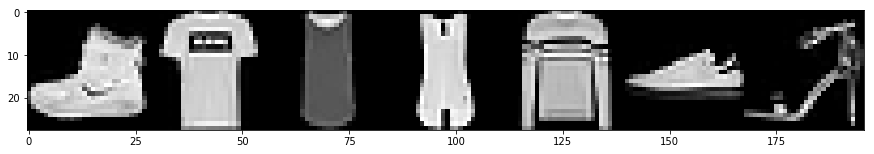

In [6]:

f=plt.figure(figsize=(15,3))
plt.imshow(np.squeeze(np.hstack(X_train[0:7])),cmap='gray') #hstack aranges the first 7 images into one long image

#Reshape
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_develop = X_develop.reshape(X_develop.shape[0], 28, 28, 1)


print("Datatype:",X_train.dtype, "\nMax value:", X_train.max())

#Notice that the pixel values imported as an integer array that saturates at `255`.  Let's turn the data into floats $\in [0, 1]$. #Jake, markdown dosn't work in comments

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

if X_train.max()>1:    #Jake, students will run into trouble if they run this cell more than once, added some logic to avoid
    X_train = X_train/255
    X_test = X_test/255
    X_develop = X_develop/255

assert(np.max(X_train) <=1)
assert(np.max(X_test) <=1)
assert(np.max(X_develop) <=1)
print("all sets scaled to float values between 0 and 1")


# The Take Away

* Image data is 3 dimensional (width,height,channel (i.e color) )
    * It is often stored from 0-255 and should be normalized between 0-1
* Class labels are given as integers and need to be converted to **one hot** vectors
    
* Multi-classification problems 
    * Use **softmax** as an output
    * Use **Categorical Cross Entropy** as a loss function


# Dense Network for Image Classification

* We can use everything we learned in Lesson 2 for Image classification
* But we need one extra layer
    * Dense Layers take 1-D data not 3-D data
    * Convert the two by Flattening
    * tf.keras.layers.Flatten()
    
All this does is reshape the input data

$\begin{pmatrix}a & b \\c & d\end{pmatrix} \rightarrow (a,b,c,d)$

Let's try the network below 


In [7]:
input_layer=tf.keras.layers.Input( shape=X_train.shape[1:] ) # Shape here does not include the batch size 

## Here is our magic layer to turn image data into something a dense layer can use
flat_input=tf.keras.layers.Flatten()(input_layer )#Dense layers take a shape of ( batch x features)
##
hidden_layer1=tf.keras.layers.Dense(100,activation='relu')(flat_input)     #Jake, define relu?
hidden_layer2=tf.keras.layers.Dense(100,activation='relu')(hidden_layer1)
output_layer=tf.keras.layers.Dense(n_targets,activation='softmax')(hidden_layer2)
dense_model=tf.keras.models.Model(input_layer,output_layer)

dense_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

dense_model.summary()

history=dense_model.fit(X_train, Y_train_one_hot, 
          batch_size=32, epochs=10, verbose=1,
         validation_data=(X_develop,Y_develop_one_hot)
         )


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________
Train on 48174 samples, validate on 11826 samples
Epoch 1/10
48174/48174 [==============================] - 4s 90us/step - loss: 0.5160 - 

## Loss Curves

The keras fit function returns a history object, that we've ignored until now, but it's a very important tool.
It records the loss of the training and development datasets at each epoch, as well as metrics like accuracy.
Let's plot the loss.

**Most imporantly**
* Is the development loss greater than the train loss?
    * If so your model is overfit and will give worse performance



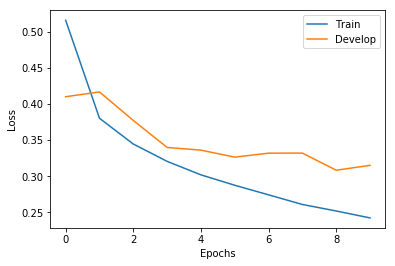

In [8]:
#We'll do this a lot so let's put it in a function
def plot_history(history):     #Jake, can we set the y-axis? plot in next cell looks bad because y-axis autoscaled
    plt.plot(history.history['loss'],label='Train')
    plt.plot(history.history['val_loss'],label='Develop')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
plot_history(history)

There are many techniques to deal with over-fitting and we'll talk more about them latter, but the easiest way is to just stop the training earlier. You can do this with


```keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)```

This is a callback, or a function that can be used to control the fitting process. It's called at the end of every epoch, or even the end of every batch. 

Train on 48174 samples, validate on 11826 samples
Epoch 1/10
48174/48174 [==============================] - 3s 62us/step - loss: 0.2186 - acc: 0.9166 - val_loss: 0.3257 - val_acc: 0.8862
Epoch 2/10
48174/48174 [==============================] - 3s 62us/step - loss: 0.2084 - acc: 0.9215 - val_loss: 0.3116 - val_acc: 0.8935
Epoch 3/10
48174/48174 [==============================] - 3s 61us/step - loss: 0.2047 - acc: 0.9215 - val_loss: 0.3225 - val_acc: 0.8886


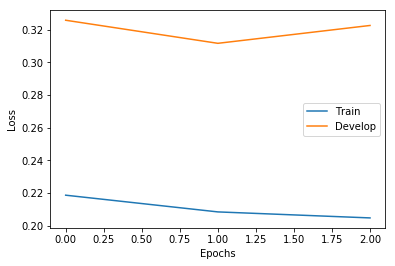

In [10]:
es=tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')
history=dense_model.fit(X_train, Y_train_one_hot, 
          batch_size=32, epochs=10, verbose=1,
         validation_data=(X_develop,Y_develop_one_hot),
          callbacks=[es] ########!!!!!!! #Jake, what?
                       )

plot_history(history)

Since we picked up training where we left off the early stopping function quits training as soon as the develop loss stops going down.

# Excerise 1

With that let's practice writing our own Dense network image classifier
We will a new dataset as an example cifar10


labels=https://www.cs.toronto.edu/~kriz/cifar.html


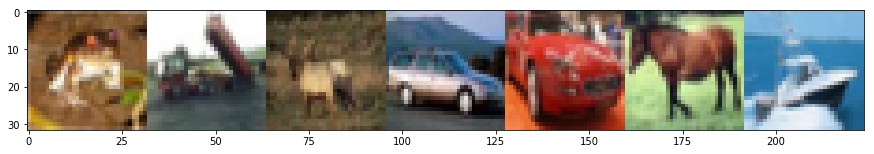

In [21]:
# Load CIFAR data into train and test sets
(_cfxtrain, _cfytrain), (cfX_test, cfY_test) = tf.keras.datasets.cifar10.load_data()

#Split into Train and Develop

train_index=[]
develop_index=[]
for i in range(len(_cfxtrain)):
    if random() <0.8:
        train_index.append(i)
    else:
        develop_index.append(i)
cfX_train=_cfxtrain[train_index]
cfY_train=_cfytrain[train_index]

cfX_develop=_cfxtrain[develop_index]
cfY_develop=_cfytrain[develop_index]

f=plt.figure(figsize=(15,3))
plt.imshow(np.hstack(cfX_train[0:7])) #hstack aranges the first 7 images into one long image



# Step 1 Scale your data to be between 0 and 1

In [22]:
"Your code here normalize cfX_train/test/develop"

print("Datatype:",cfX_train.dtype, "\nMax value:", cfX_train.max())

cfX_train = cfX_train.astype('float32')
cfX_test = cfX_test.astype('float32')

if cfX_train.max()>1:    #Jake, students will run into trouble if they run this cell more than once, added some logic to avoid
    cfX_train = cfX_train/255
    cfX_test = cfX_test/255
    cfX_develop = cfX_develop/255
print("Datatype:",cfX_train.dtype, "\nMax value:", cfX_train.max())

Datatype: uint8 
Max value: 255
Datatype: float32 
Max value: 1.0


In [24]:
for data_set in [cfX_train,cfX_develop,cfX_test]:
    assert np.max(data_set)==1., 'Max of your data set is '+str(np.max(data_set))+' not 1'
    assert np.min(data_set)==0., 'Max of your data set is '+str(np.min(data_set))+' not 0'

print('Great job! Your dataset is normalized correctly')

Great job! Your dataset is normalized correctly


# Step 2 Create One-Hot encoded labels
Name them:
* cfY_train_one_hot
* cfY_develop_one_hot
* cfY_test_one_hot


In [25]:
"Your code here"

cfY_train_one_hot = tf.keras.utils.to_categorical(cfY_train, 10)
cfY_develop_one_hot =  tf.keras.utils.to_categorical(cfY_develop, 10)
cfY_test_one_hot =  tf.keras.utils.to_categorical(cfY_test, 10)

print('Example:',cfY_train[0],'=',cfY_train_one_hot[0])

Example: [6] = [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [27]:
assert 'cfY_train_one_hot' in locals(),  'cfY_train_one_hot not found' 
assert 'cfY_develop_one_hot' in locals(),  'cfY_develop_one_hot not found' 
assert 'cfY_test_one_hot' in locals(),  'cfY_test_one_hot not found' 

assert (cfY_train_one_hot).shape[1]==10,  'cfY_train_one_hot not the correct size' 
assert (cfY_develop_one_hot).shape[1]==10,  'cfY_develop_one_hot not the correct size' 
assert (cfY_test_one_hot).shape[1]==10,  'cfY_test_one_hot not the correct size'
print("One-Hot encoded labels created, correct size")

One-Hot encoded labels created, correct size


# Step 3 Create a Dense Neural Network
Write your own dense image classifier.

Remeber you'll need: 
* an input layer
* a flatten layer
* some dense layers with activations
* an output layer with a softmax activation

Create and compile a model named **cifar_model**
* Make sure the loss is catagorical_crossentropy


In [32]:
"your code here"

cfinput_layer=tf.keras.layers.Input( shape=cfX_train.shape[1:] ) # Shape here does not include the batch size 

## Here is our magic layer to turn image data into something a dense layer can use
cfflat_input=tf.keras.layers.Flatten()(cfinput_layer )#Dense layers take a shape of ( batch x features)
##
cfhidden_layer1=tf.keras.layers.Dense(100,activation='relu')(cfflat_input)     #Jake, define relu?
cfhidden_layer2=tf.keras.layers.Dense(100,activation='relu')(cfhidden_layer1)
cfoutput_layer=tf.keras.layers.Dense(n_targets,activation='softmax')(cfhidden_layer2)
cifar_model=tf.keras.models.Model(cfinput_layer,cfoutput_layer)

cifar_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

cifar_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               307300    
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1010      
Total params: 318,410
Trainable params: 318,410
Non-trainable params: 0
_________________________________________________________________


In [29]:
assert 'cifar_model' in locals(), "Could not find cifar_model"
assert cifar_model.input_shape ==(None,32,32,3), "Check your input shape is correct"
assert cifar_model.output_shape[1] ==10, "Check your output shape is correct"
assert cifar_model._is_compiled, "Make sure to compile your model"
assert cifar_model.loss=='categorical_crossentropy', "Check your loss to make sure it's correct"
assert (np.abs(np.sum(cifar_model.predict(cfX_train[0:10]),axis=1)-1) < 1e-5).all(), "Outputs don't sum to 1 make sure you have the correct activation"

print('Fantastic Job! It looks like your model is ready to fit.')

Fantastic Job! It looks like your model is ready to fit.


## Step 4: Fit your Model

In [30]:

history=cifar_model.fit(cfX_train, cfY_train_one_hot, 
          batch_size=32, epochs=10, verbose=1,
         validation_data=(cfX_develop,cfY_develop_one_hot)
         )


Train on 40030 samples, validate on 9970 samples
Epoch 1/10
40030/40030 [==============================] - 5s 124us/step - loss: 1.4876 - acc: 0.4671 - val_loss: 1.5621 - val_acc: 0.4459
Epoch 2/10
40030/40030 [==============================] - 5s 122us/step - loss: 1.4787 - acc: 0.4685 - val_loss: 1.5391 - val_acc: 0.4516
Epoch 3/10
40030/40030 [==============================] - 5s 123us/step - loss: 1.4656 - acc: 0.4737 - val_loss: 1.5529 - val_acc: 0.4455
Epoch 4/10
40030/40030 [==============================] - 5s 122us/step - loss: 1.4620 - acc: 0.4786 - val_loss: 1.5242 - val_acc: 0.4523
Epoch 5/10
40030/40030 [==============================] - 5s 122us/step - loss: 1.4512 - acc: 0.4801 - val_loss: 1.4953 - val_acc: 0.4706
Epoch 6/10
40030/40030 [==============================] - 5s 123us/step - loss: 1.4510 - acc: 0.4782 - val_loss: 1.5098 - val_acc: 0.4656
Epoch 7/10
40030/40030 [==============================] - 5s 123us/step - loss: 1.4411 - acc: 0.4809 - val_loss: 1.4884 - v

## Step 5: Plot your loss curves

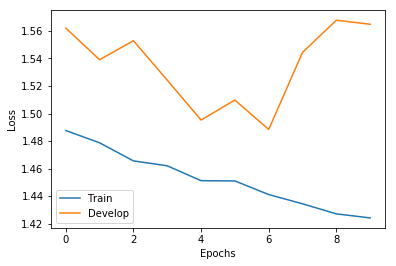

In [31]:
"your code here"

plot_history(history)

# Convolutional Neural Networks


The above networks may or may not have worked particularly well, and while it's possible to get a network like this give you good accuracy all the time it requires some work, tunning, and has a bigger issue. Look at the summary of our first neural network





```
Layer (type)           Output Shape              Param #  
=================================================================
flatten (Flatten)      (None, 784)               0       
_________________________________________________________________

dense(Dense)           (None, 100)              78500      
_________________________________________________________________
 ```


our first layer has 28 * 28 * 1 * 100 = 78,500 weights, which is fine for this size image.  What about using even a low resolution image of 300 * 300 * 3 * 100= 27 Million parameters for one layer. This is still possible with modern GPUs, but does not general yield good results. We need a solution that does not scale with with the number of pixels!



A 300x300x3 pixel Image
<img src="../assets/small_img.jpg" style="width:100">

Neural Networks also don't fully utilize what we know about images for example we know that a rock above would still be a rock if we've moved it several pixels to the right of left, but a Dense network would have to learn a whole new set of weights to find a rock a every location in an image. This isn't very efficient. 

* Dense Neural networks treat each pixel as a separate features
    * In image analysis we are often looking for a group of pixels somewhere in an image
        *i.e. Cells, Tumors, or Ankle boots
* We can use a new Layer that looks at a small patch of the image to create an interesting feature
    * This is a **Convolutional Neural Network**


<img src="http://cs231n.github.io/assets/cnn/cnn.jpeg" style="width:100">


CNNs preserve the spatial (2-D) information of the input images, add a depth to their layers, and reduce the number of connections (and therefore weights).

The layers used to build CNN *architectures* fall into three categories:
 1. Convolutional Layer
 1. Pooling Layer
 1. Fully-Connected Layer

## Convolutional layer

<img src="http://cs231n.github.io/assets/cnn/depthcol.jpeg" style="width=100">

Convolutional layers consist of a set of filters that apply over a small spatial area, but the full depth of the input.  The example above shows on the left a [32x32x3] input volume (width 32, height 32 image with RGB color channels).  The volume on the right is an example of a convolutional layer, with a particular **depth column** highlighted which takes as input *only* the highlighted region of the input volume.  The spatial extent of the area covered by a depth column is referred to as the **receptive field**.

The dimensions of the *output volume* are decided by 3 hyperparameters: **depth**, **stride**, and **zero-padding**.  We can compute the size of the output volume based on the volume size $W$, the receptive field size of the convolution layer $F$, their applied stride $S$, and the amount of zero padding used $P$.

Based on these parameters, the number of pixels in the output of a convolutional layer is $(W−F+2P)/S+1$. 

<img src="http://cs231n.github.io/assets/cnn/stride.jpeg">

### Parameter sharing

Above is a 1-D example with inputs on the bottom in blue ($W=5$) with a padding of 1 ($P=1$), and two different examples of a convolutional filter in red, both with receptive field $F=3$.

*Left*: This is a convolutional layer with stride $S = 2$, meaning we expect ($5 - 3 + 2)/2+1 = 5$ neurons (i.e., outputs).

*Right*: Layer with stride $S = 2$, meaning an output of size $(5 - 3 + 2)/2+1 = 3$.

Note how on the left the zero padding allowed us to have the same number of outputs as inputs.  This is a common use of zero-padding.

We can dramatically reduce the number of parameters involved in a convolutional layer by making the assumption that if one feature is useful to compute at some spatial position (x,y), then it should also be useful to compute at a different position (x2,y2).

In other words, denoting a single 2-dimensional slice of depth as a depth slice (e.g. a volume of size [7x7x3] has 3 depth slices, each of size [7x7]), we are going to constrain the pixels in each depth slice to use the same weights and bias. All $7\times7$ pixels in each depth slice will now be using the same parameters.


<img src="https://harishnarayanan.org/images/writing/artistic-style-transfer/conv-layer.gif">



Lets look at the how the first output pixel is calculated

|X[0:3,0:3,0]|W0[:,:,0]| 
|------ | ------|
|0,0,0  |-1,0,1|
|0,0,0  |0,0,1 |
|0,1,0  |1,-1,1|
|first channel = | -1|
+
|X[0:3,0:3,1]|W0[:,:,1]|
|0,0,0  |-1,0,1|
|0,2,1  |1,-1,1|
|0,2,1  |0,1,0|
|second channel = |1|
+
|X[0:3,0:3,2]|W0[:,:,2]|
|0,0,0  |-1,1,1|
|0,2,1  |1,1,0 |
|0,1,0  |0,-1,0|
|third channel= | 1|
|bias = |1 |
|Sum Total| 2 = O[0,0,0]|



## Pooling

Pooling layers act to reduce the dimension of the propagated volume, reducing the number of weights going forward, reducing cost and reducing the chances of over-fitting.  It operates independently on each depth slice.  A common operation is to take the MAX over a region.

<img src="http://cs231n.github.io/assets/cnn/pool.jpeg" style="width:300">

For example,
<img src="http://cs231n.github.io/assets/cnn/maxpool.jpeg" style="width:500">

**NOTE**: These are being used less and less these days, in favor of other methods such as strided convolutions seen above.



Let's return to the MNIST hand-written digits data set.  First we'll download some external images that will be useful for visualizations later.

## An Example Model

In keras we can do everything we discussed above by adding an extra layer


* tf.keras.layers.Convolution2D(Number of Filters, (Filter Size)

## Our example model
* One convolutional layer
    * 10 Filters
    * Each filter (28x28)
* Maxpooling
* Softmax layer

Each filter is the size of our entire image, and goes directly into predictions

**Note**: This is not a standard algorithm design, but does show
* How a filter works
* How we can view intermediate layers
* Will build some intuition when using CNNs



In [ ]:
cnn_input=tf.keras.layers.Input( shape=X_train.shape[1:] ) # Shape here does not including the batch size 
cnn_layer1=tf.keras.layers.Convolution2D(10, (28,28),padding='same')(cnn_input) 
cnn_activation=tf.keras.layers.LeakyReLU()(cnn_layer1) 
max_pooling=tf.keras.layers.MaxPooling2D(28)(cnn_activation) 
flat=tf.keras.layers.Flatten()(max_pooling) 
output=tf.keras.layers.Activation('softmax')(flat)
model=tf.keras.models.Model([cnn_input],[output])
model.summary()


model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


history=model.fit(X_train, Y_train_one_hot, 
          batch_size=32, epochs=5, verbose=1,
         validation_data=(X_develop,Y_develop_one_hot)
         )

## Looking under the hood

* We can use something called a keras function to explore our model layer by layer
* A keras function is a lot like a keras Model, but doesn't have and code to do things like fitting

tf.keras.backend.function([...Inputs...],[...outputs...])

In [ ]:
#A function to get the output of all layers (except the first which is the input layer)
image_index=8


layers=tf.keras.backend.function([model.input],[ l.output for l in model.layers[1:]])


layers_output=layers([X_train[image_index:image_index+1]]) 
 
print("Input")
plt.imshow(np.squeeze(X_train[image_index]),cmap='gray')
plt.show()

print("CNN layer filters")

filters=np.squeeze(model.layers[1].get_weights()[0])
print(filters.shape)
filter_stack=np.hstack([filters[:,:,i] for i in range(10)   ])
f=plt.figure(figsize=(20,2))

plt.imshow(filter_stack,cmap='gray')
plt.show()

print("CNN Layer Output")


print(layers_output[0].shape)
cnn_out=np.squeeze(layers_output[0])

cnn_stack=np.hstack([cnn_out[:,:,i] for i in range(10)   ])
f=plt.figure(figsize=(20,2))
plt.imshow(cnn_stack,cmap='gray')
plt.show()    


print("Activation")
act_out=np.squeeze(layers_output[1])

act_stack=np.hstack([act_out[:,:,i] for i in range(10)   ])
f=plt.figure(figsize=(20,2))
plt.imshow(act_stack,cmap='gray')
plt.show()    


print("Pooling")
pool_out=np.squeeze(layers_output[2])
print(pool_out)

#layer 3 is just a Flatten

print("Softmax")
p_out=np.squeeze(layers_output[4])
print(p_out)




## Building a better model

1. The simplest thing to improve the above model is to add a Dense layer at the end
    * The Convolutional layer will learn the features that go into the dense network
**Try the above model with a Dense layer at the end **
* Can you still make sense of the filter's?

2. Use smaller filters

The above model (without the Dense layer) essentially learned a template for each class, this worked ok, but doesn't work in general or if you have a huge number of classes. Instead of using a few big filters, we can use a number of small filters, and stack them into deep networks.

* This model will use several small filters
* The layers will be stacked
    * Earlier layer's will do simple things like edge detection
    * Later layers will take those edges as features which lets them learn more complex objects
    
3. Replace MaxPooling with Strided Convolutions
    * Let's the model learn the best way to downsize


In [ ]:
cnn_input=tf.keras.layers.Input( shape=X_train.shape[1:] ) # Shape here does not including the batch size 
cnn_layer1=tf.keras.layers.Convolution2D(64, (4,4),strides=2,padding='same')(cnn_input) 
cnn_activation=tf.keras.layers.LeakyReLU()(cnn_layer1) 

cnn_layer2=tf.keras.layers.Convolution2D(64, (4,4),strides=2,padding='same')(cnn_activation) 
cnn_activation=tf.keras.layers.LeakyReLU()(cnn_layer2) 

cnn_layer3=tf.keras.layers.Convolution2D(64, (4,4),strides=2,padding='same')(cnn_activation) 
cnn_activation=tf.keras.layers.LeakyReLU()(cnn_layer3) 

flat=tf.keras.layers.Flatten()(cnn_activation) 

dense_layer=tf.keras.layers.Dense(10)(flat) 
output=tf.keras.layers.Activation('softmax')(dense_layer)

model=tf.keras.models.Model([cnn_input],[output])
model.summary()



model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


history=model.fit(X_train, Y_train_one_hot, 
          batch_size=32, epochs=5, verbose=1,
         validation_data=(X_develop,Y_develop_one_hot)
         )


In [ ]:
plot_history(history)


# Overfitting

Overfitting generally refers to a trend for ML models to find and exploit statistical fluctuations in your training data that don't accurately reflect the system you are trying to learn. You can think of this a 'memorizing' without any real understanding. A good way of testing whether this is happening or not is to compare the training loss to the loss calculated on a new set of data (with it's own different statistical fluctuations)

* Overfitting is combated 
    * with Dropout (more on that later)
    * with less training or Early stopping (see https://keras.io/callbacks/#earlystopping)

Keras's fit function returns a history object that shows the loss of the training and testing set we can check it for signs of overfitting.

* You expect for the training and testing loss to go down 
* If the model starts overfitting 
    * you'll see the testing loss stop decreasing and even go up 
    * Training loss will continue to go down
* An important detail: Keras has two learning_phases
    * Training: The Model is training and dropout is on reducing available information
    * Testing: This is the setting when using the model for real, dropout is disabled
    * The Training loss is calculated with the training phase (dropout on)
    * The Testing loss is calculated with the testing phase (dropout off)
        * You will often see the Training loss is greater than the testing loss, this is okay if you're using dropout
        * It might not be okay if you're using your own data without dropout
            * Could be a sign the testing data is distributed differently than the training data

In [ ]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.legend()
plt.xlabel('Epoch')
plt.show()

Any sign of overfitting?

# Prediction
Lets look at how the model makes predictions


In [ ]:
pred=model.predict(X_test)
for i,p in enumerate(pred[0]):
    print(lookup_dict[i],round(p*100,2),'%')

best_guess=np.argmax(pred[0])
print('best guess:',lookup_dict[best_guess])
plt.imshow(np.squeeze(X_test[0]),cmap='gray')
plt.show()

print('Truth Class:',Y_test[0],lookup_dict[Y_test[0]])


Notice Above that the while the most likely guess is correct (Ankle boot when I ran it 23.2 percent), the model still isn't that confident in it's result. So while the accuracy is good there is still some improvements that might give you better confidences, and lower losses.  

## Other Checks

### Confusion matrix
    A confusion matrix is a 2-D histogram with the dimensions being the true class, and the predicted class.
    The diagonal bins in this histogram are correct prediction true_class==predicted_class, otherwise it is an
    incorrect prediction. Run the cell below and see if you can guess which class is hardest to identify

In [ ]:
def check(model,X_test,Y_test):
    pred=model.predict(X_test)
    print(pred.shape)
    best_guess=np.argmax(pred,axis=1)

    confusion_matrix=np.zeros((n_targets,n_targets))
    for truth,guess in zip(Y_test,best_guess): #Note lower case y for the data without 1-hot encoding    
        confusion_matrix[truth,guess]+=1

    plt.imshow(confusion_matrix)
    plt.xlabel('Prediction')
    plt.ylabel('Truth')
    plt.xticks(range(0,10),labels,rotation=90)
    plt.yticks(range(0,10),labels)

    plt.show()
    print('Number of Incorrect Guesses:',np.sum(best_guess!=Y_test))

    
    prediction_for_true_value=[p[i] for p,i in zip(pred,Y_test)  ]

    bins=plt.hist(prediction_for_true_value,bins=30,range=(0,1))
    plt.title('Output for Correct Classes')
    
    worst=np.argsort(prediction_for_true_value)


    plt.show()
    plt.show()

    for index in worst[0:5]:
        print("Guess:", lookup_dict[best_guess[index]], "/Truth:",lookup_dict[Y_test[index]])
        plt.imshow(np.squeeze(X_test[index]),cmap='gray')

        plt.show()


check(model,X_test,Y_test)




## Tips and Tricks

* Dropout
* Data Augmentation
* Which Activation functions to use inside your network


In [ ]:
#Lets Put of this together into some helpful functions
def build_model(dropout_rate=0.25,nfilters=32,use_leakyRelu=False,activation='relu'):
    if use_leakyRelu:
        activation='linear'
    
    cnn_input=tf.keras.layers.Input( shape=X_train.shape[1:] ) # Shape here does not include the batch size 
    cnn_layer1=tf.keras.layers.Convolution2D(nfilters, (3, 3), activation=activation)(cnn_input) #Notice here calling the layer with cnn_input as an argument connects the input layer to this layer 
    if use_leakyRelu:cnn_layer1=tf.keras.layers.LeakyReLU()(cnn_layer1)
    cnn_layer2=tf.keras.layers.Convolution2D(nfilters, (3, 3), activation=activation)(cnn_layer1)
    if use_leakyRelu:cnn_layer2=tf.keras.layers.LeakyReLU()(cnn_layer2)

    max_pool=tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(cnn_layer2)
    dropout=tf.keras.layers.Dropout(dropout_rate)(max_pool)
    flat=tf.keras.layers.Flatten()(dropout)
    
    dense1=tf.keras.layers.Dense(128, activation=activation)(flat)

    dropout_output=tf.keras.layers.Dropout(dropout_rate)(dense1)
    output_no_a=tf.keras.layers.Dense(10)(dropout_output)
    output=tf.keras.layers.Activation('softmax')(output_no_a)
    model=tf.keras.models.Model([cnn_input],[output])
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    return model
    
def plot_history(history):
    plt.plot(history.history['loss'],label='Training Loss')
    plt.plot(history.history['val_loss'], label='Testing Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()
    
    

# Dropout

A great diagram I took from the link below.

<img src="https://cdn-images-1.medium.com/max/1600/1*f8YjtxaYPid1Ilkw0tImaw.png">
<a href=https://medium.com/@ahmdtaha/dropout-as-a-bayesian-approximation-representing-model-uncertainty-in-deep-learning-7a2e49e64a15> Link to Article </a>


Dropout randomly removes X% (where x is a hyperparameter) of the data from the previous layer, which makes memorizing the data much more difficult. This encourages the model to learn meaningful and independent features.

Lets look what happens when we train different models, with only a small fraction training dataset (500 images)


### Dropout 0% (no dropout)
<img src="../assets/dropout_0.png"  >
This modek quickly overfits

### Dropout 50%
<img src="../assets/dropout_0_50.png" >
This model does a bit better but over time still overfits


### Dropout 70%
<img src="../assets/dropout_0_70.png"  >
This model overfits even slower


### Dropout 90%
<img src="../assets/dropout_0_90.png" >
This model does not overfit, but takes much longer to train







In [ ]:
import numpy as np
print(X_train.shape)
train_data=np.random.choice(range(0,len(X_train))  ,500 )

In [ ]:

for rate in [0,0.5,0.7,0.9]:
    new_model=build_model(dropout_rate=rate)
    print('Dropout Rate ',rate)
    history=new_model.fit(X_train[train_data], Y_train[train_data], 
          batch_size=32, epochs=200, verbose=0,
         validation_data=(X_test,Y_test) )
    score = new_model.evaluate(X_test, Y_test, verbose=0)
    print("Test loss: {}, Test accuracy: {}".format(*score))

    score = new_model.evaluate(X_train[train_data], Y_train[train_data], verbose=0)
    print("Train loss: {}, Train accuracy: {}".format(*score))

    
    plot_history(history)


# Activations

Activations vary mainly on the output layer of a network
* Binary Classification: Sigmoid
* Multi-Class Classification: SoftMax
* Regression: Linear


However, activations can have a large impact on training. 
* I normally use a LeaklyReLU as my default choice
  * Has non zero derivatives at +/- infinity

See how some of the activation change below


In [ ]:
x=np.expand_dims(np.linspace(-10,10,50),1)

act_input=tf.keras.Input((1,)) #Notice the comma after 1, this is a 1 dimentional input to keras
output=tf.keras.layers.LeakyReLU()(act_input) #This is an "Advanced Activation, so it has it's own layer"


sess=tf.keras.backend.get_session()
output=sess.run(output,feed_dict={act_input:x})
plt.plot(x,output)
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('LeakyReLU')
plt.show()
for activation in ['elu','selu','relu','softplus','softsign','tanh','sigmoid','hard_sigmoid','linear']:
    output=tf.keras.layers.Activation(activation)(act_input) 
    sess=tf.keras.backend.get_session()
    output=sess.run(output,feed_dict={act_input:x})
    plt.plot(x,output)
    plt.xlabel('Input')
    plt.ylabel('Output')
    plt.title(activation)
    plt.show()


## Sigmoid

In [ ]:
model=build_model(dropout_rate=0.50,nfilters=32,activation='sigmoid')
history=model.fit(X_train, Y_train, 
      batch_size=32, epochs=10, verbose=0,
     validation_data=(X_test,Y_test) )
score = model.evaluate(X_test, Y_test, verbose=0)
print("Test loss: {}, Test accuracy: {}".format(*score))

score = model.evaluate(X_train[train_data], Y_train[train_data], verbose=0)
print("Train loss: {}, Train accuracy: {}".format(*score))
check(model,X_test,Y_test)
plot_history(history)

## Leaky ReLU

In [ ]:
model=build_model(dropout_rate=0.50,nfilters=32,use_leakyRelu=True)
history=model.fit(X_train, Y_train, 
      batch_size=32, epochs=10, verbose=0,
     validation_data=(X_test,Y_test) )
score = model.evaluate(X_test, Y_test, verbose=0)
print("Test loss: {}, Test accuracy: {}".format(*score))

score = model.evaluate(X_train[train_data], Y_train[train_data], verbose=0)
print("Train loss: {}, Train accuracy: {}".format(*score))
check(model,X_test,Y_test)
plot_history(history)

# Give it a Try on the cifar dataset
* Write your on Image classifier with Convolutional Neural Networks